# 3D Segmentation of Brain Tumor

This document is to propose a 2D methodology instead of treating it as a 3D input.


## Loading the Dataset
The dataset used is the BraTS 2020 Dataset.

The Dataset Contains the Following Scans per case:

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

So for training T1ce, T2 and FLAIR will be used.

In [299]:
# Previewing the MRI Data
# TODO: Collect all imports later and add notes next to them
import numpy as np
import matplotlib.pyplot as plt
from os import path, listdir
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    EnsureTyped,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
)

import pytorch_lightning as pl
import torch


In [300]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"./MICCAI_BraTS2020_TrainingData"
cases = [path.join(TRAINING_DATASET_PATH, x) for x in listdir(TRAINING_DATASET_PATH)]


In [301]:
# Prepare a list of dictionaries of T1CE, T2, FLAIR and Ground Truth Segmentation for preparing the Dataset to be used in the Data Loader
mri_cases_dictionary = [
    {
        "image": [
            path.join(case, f"{path.split(case)[-1]}_t1ce.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_t2.nii.gz"),
            path.join(case, f"{path.split(case)[-1]}_flair.nii.gz"),
        ],
        "seg": path.join(case, f"{path.split(case)[-1]}_seg.nii.gz"),
    }
    for case in cases[:5]  # ! Only 2 cases taken as test slice
]


In [302]:
# One Hot Encoding for Tumor as 3 is skipped in the segmentation masks.
class ConvertLabelsIntoOneHotd(MapTransform):
    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                data_dict[key] == 1,  # Non Enhancing Tumor Core
                data_dict[key] == 2,  # Edema Core
                data_dict[key] == 4,  # Enhancing Tumor Core
            ]
            data_dict[key] = np.stack(one_hot_encode_array, axis=0).astype(np.float32)
        return data_dict


In [303]:
# Transform data such as from niftii into Tensors
transform_training_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image", "seg"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        # Orientationd(keys=["image", "seg"], axcodes="RAS"),
        #! Causes misalignment on Mask
        Spacingd(
            keys=["image", "seg"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [304]:
# Prepare the training Dataset with all transformations
# Optional: Can replace Dataset Class with Cache Dataset
dataset_training = Dataset(mri_cases_dictionary, transform_training_dataset)


In [305]:
print(dataset_training[0]["image"].shape)
print(dataset_training[0]["seg"].shape)

torch.Size([3, 240, 240, 155])
torch.Size([3, 240, 240, 155])


Dataset Produced in the following format
```
[list of dictionaries]
    - mri scan ["image"] -> [3,240,240,155] [Torch.Tensor]
    - seg mask ["seg] -> [3,240,240,155] [Torch.Tensor]
```

Where `[3,240,240,155]` refers to `[Channel,Dims..]`


## Visualising the Training Dataset

Text(0.5, 1.0, 'Enhancing')

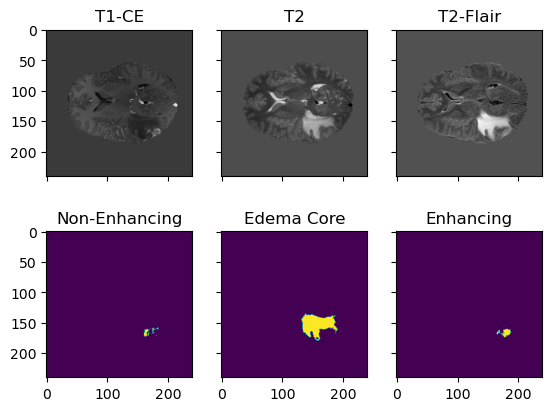

In [307]:
# Visualising the Training Dataset per case

#! Misalignment of Seg and Image Tensors when using Orientationd

case = 3  # Refers to a folder in the training dataset such as "./MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/"

slice = 68  # Refers to a slice in the 3D Tensor. For visualisation one of the 3 axis must be limited

to_plot_case = dataset_training[case]

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0, 0].imshow(to_plot_case["image"][0][:, :, slice], cmap="gray")
ax[0, 0].set_title("T1-CE")

ax[0, 1].imshow(to_plot_case["image"][1][:, :, slice], cmap="gray")
ax[0, 1].set_title("T2")

ax[0, 2].imshow(to_plot_case["image"][2][:, :, slice], cmap="gray")
ax[0, 2].set_title("T2-Flair")


ax[1, 0].imshow(to_plot_case["seg"][0][:, :, slice])
ax[1, 0].set_title("Non-Enhancing")

ax[1, 1].imshow(to_plot_case["seg"][1][:, :, slice])
ax[1, 1].set_title("Edema Core")

ax[1, 2].imshow(to_plot_case["seg"][2][:, :, slice])
ax[1, 2].set_title("Enhancing")


# TODO
- Data Preprocessing
- Choosing Data Loader -> Slice
- Choosing Encoder
- Choosing Decoder -> Append Encoder

add more as you go

In [ ]:
class Segmentation_Model(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.batch_size = 1
        self.num_workers = 2
        self.learning_rate = 1e-4

        self.model = None
        # TODO: Define Models, Loss Functions and Metrics



    # Data preparation
    def prepare_data(self):
        # Load the dataset once on model is instantiated
        self.train_ds = dataset_training
        # TODO: validation dataset

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_ds,
            shuffle=True,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_ds,
            shuffle=True,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    # Training and Validation
    def forward(self,x):
        # return self.Model -> Forward Pass
        pass

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def training_step(self,batch, batch_idx):
        # image, seg = batch["image"], batch["seg"]
        # output = self.forward(image)
        # loss = self.loss_function(output, seg)
        # tensorboard_logs = {"train_loss": loss.item()}
        # return {"loss": loss, "log": tensorboard_logs}

        '''
        In the traning loop pass slice from the each 3d view
        Ex: 
        for i in range (batch["image"].size(4)):
            pass each slice to model

        follow models input standard -> [Batch, Channel, Dims]
        '''

        pass
    

    def validation_step(self,batch, batch_idx):
        # image, seg = batch["image"], batch["seg"]
        # output = sliding_window_inference(
        #     inputs=image,
        #     roi_size=(240, 240, 160),
        #     sw_batch_size=1,
        #     predictor=self.forward,
        #     overlap=0.5,
        # )
        # loss = self.loss_function(output, seg)
        # output = [self.post_pred_image(i) for i in decollate_batch(output)]
        # self.dice_metric(y_pred=output, y=seg)
        # return {"val_loss": loss, "val_number": len(output)}
        pass

    def validation_epoch_end(self):
        # val_loss, num_items = 0, 0
        # for output in outputs:
        #     val_loss += output["val_loss"].sum().item()
        #     num_items += output["val_number"]
        
        # mean_val_dice = self.dice_metric.aggregate().item()
        # self.dice_metric.reset()
        # mean_val_loss = torch.tensor(val_loss / num_items)
        
        # tensorboard_logs = {
        #     'val_dice': mean_val_dice,
        #     'val_loss': mean_val_loss
        # }
        # if mean_val_dice > self.best_val_dice:
        #     self.best_val_dice = mean_val_dice
        #     self.best_val_epoch = self.current_epoch
        # print(
        #     f"current epoch: {self.current_epoch} "
        #     f"current mean dice: {mean_val_dice:.4f}"
        #     f"\nbest mean dice: {self.best_val_dice:.4f} "
        #     f"at epoch: {self.best_val_epoch}"
        # )
        # return {"log": tensorboard_logs}
        pass

In [310]:
dataset_training_loader = torch.utils.data.DataLoader(
            dataset_training,
            shuffle=True,
            batch_size=2,
        )
for idx,batch in enumerate (dataset_training_loader):
    print(batch["image"].shape)
    for i in range (batch["image"].size(4)):
        pass
    print(idx,i)


c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\monai\transforms\spatial\array.py:571: UserWarning: `data_array` is not of type MetaTensor, assuming affine to be identity.
  warnings.warn("`data_array` is not of type MetaTensor, assuming affine to be identity.")


torch.Size([2, 3, 240, 240, 155])
0 154
torch.Size([2, 3, 240, 240, 155])
1 154
torch.Size([1, 3, 240, 240, 155])
2 154
